# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

### 1) Portfolio Dataframe

In [3]:
# View the shape of the portfolio data set
portfolio.shape

(10, 6)

In [4]:
# Assess the portfolio data set
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# View the info of the portfolio data set
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
# view descriptive statistics of portfolio data set
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
# Check for null values in the portfolio data set
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

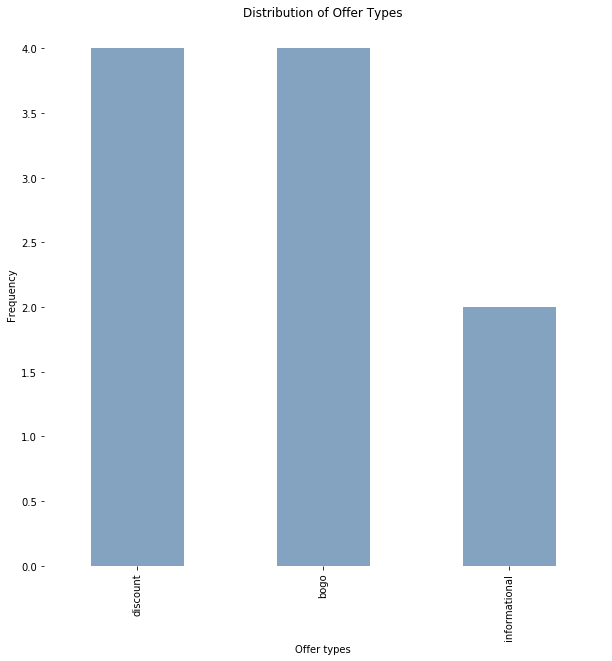

In [8]:
# Plot the bar chart of the distribution of the offer types
ax = portfolio.offer_type.value_counts().plot.bar(figsize=(10, 10), color=(0.2, 0.4, 0.6, 0.6))
ax.set_title('Distribution of Offer Types')
ax.set_xlabel('Offer types')
ax.set_ylabel('Frequency')
sns.despine(bottom=True, left=True)

### 2) Profile Dataframe

In [9]:
# View shape of profile data set
profile.shape

(17000, 5)

In [10]:
# Assess profile data set
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
# Assess attributes of profile data set
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
# Assess descriptive statistics of profile dataframe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
# Assess null values in the profile dataframe
profile.isnull().any().sum()

2

In [14]:
# Assess the null values in each column of the profile dataframe
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

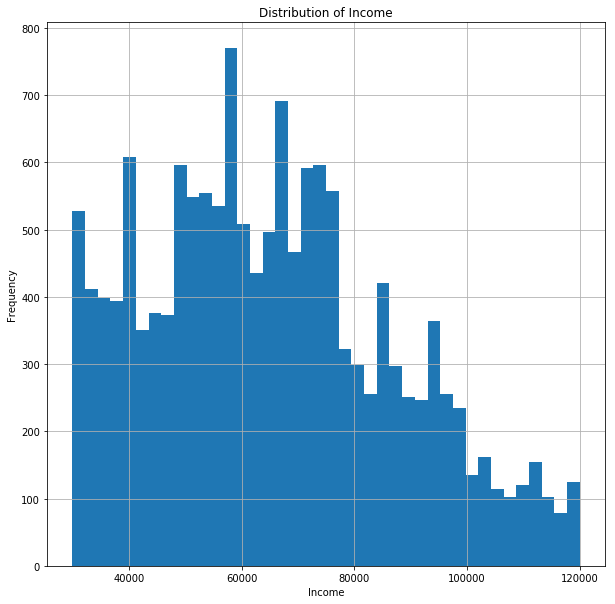

In [16]:
# Plot the histogram of the distribution of the income column
profile.income.hist(bins=40, figsize=(10, 10))
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency');

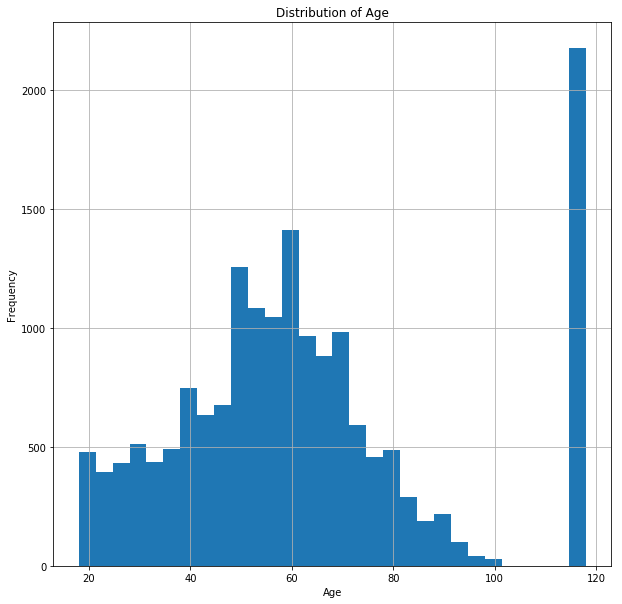

In [17]:
# Plot the histogram of the distribution of the age column
profile.age.hist(bins= 30, figsize=(10, 10))
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');

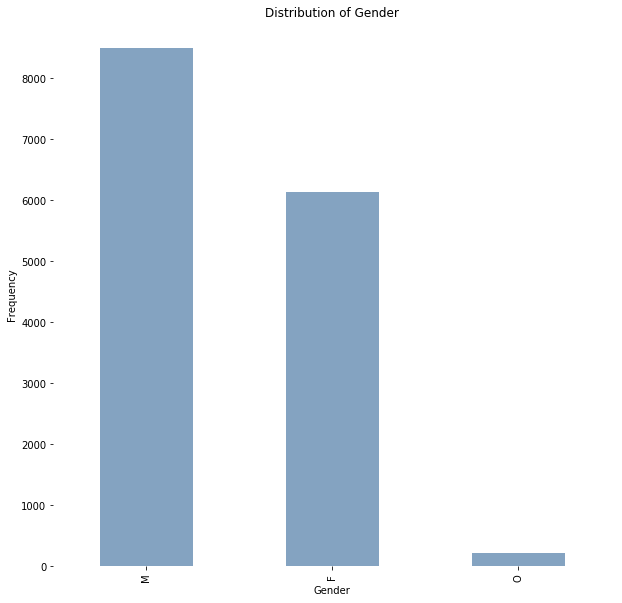

In [18]:
# Plot the bar chart of the distribution of the age column
ax = profile.gender.value_counts().plot.bar(figsize=(10, 10), color=(0.2, 0.4, 0.6, 0.6))
ax.set_title('Distribution of Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Frequency')
sns.despine(bottom=True, left=True)

### 3) Transcript Dataframe

In [19]:
# View shape of transcript dataframe
transcript.shape

(306534, 4)

In [20]:
# Assess transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
# View atrributes of transcript dataframe
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
# Assess the descriptive statistics of the transcript dataframe
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [23]:
# Assess null values in the transcript dataframe
transcript.isnull().any().sum()

0

In [24]:
# Assess the null values in each column of the transcript dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [25]:
# Asses the event column of the transcript dataframe for the unique values in the column
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [26]:
# Assess the total number of customers in the transcript column
transcript.person.nunique()

17000

In [27]:
# Explore the offers sent to a particular customer
transcript.query("person == '78afa995795e4d85b5d9ceeca43f5fef'")

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


# Data Cleaning

## 1) Portfolio Data Set

In [28]:
# Write a function that cleans the portfolio data frame
def clean_portfolio(portfolio):
    '''
    cleans the portfolio dataframe and cleans it by applying one-hot encodings to the columns
    
    INPUT:
    portfolio dataframe - dataframe to be cleaned
        
    OUTPUT:
    cleaned dataframe that consists of:
    i) One-hot encoded channels column
    ii) One-hot encoded columns
    '''
    
    # Make a copy of the portfolio dataframe
    portfolio_clean = portfolio.copy()
    
    # Apply one hot encoding to channels column
    portfolio_clean['web'] = portfolio_clean['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio_clean['email'] = portfolio_clean['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio_clean['mobile'] = portfolio_clean['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio_clean['social'] = portfolio_clean['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # Apply one-hot encoding to the offer type column
    offer_type = pd.get_dummies(portfolio_clean['offer_type'])
    
    # Drop the channels and offer_type column
    portfolio_clean.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # Concat one-hot and df
    portfolio_clean = pd.concat([portfolio_clean, offer_type], axis=1, sort=False)

    
    # Organize columns
    cols = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    portfolio_clean = portfolio_clean[cols]
    
    return portfolio_clean

In [29]:
portfolio_clean = clean_portfolio(portfolio)

In [30]:
portfolio_clean

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


In [31]:
portfolio_clean.shape

(10, 11)

## 2) Profile Dataframe

In [32]:
def clean_profile(profile):
    """
    cleans the profile dataframe by applying one-hot encodings to the columns and also 
    taking care of the null values and the 118 value in the age column.
    
    INPUT:
    profile dataframe - dataframe to be cleaned
        
    OUTPUT:
    cleaned profile dataframe
    """
    
    # Make a copy of the profile dataframe
    profile_clean = profile.copy()
    # age: (numeric) missing value encoded as 118
    profile_clean['age'] = profile_clean['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile_clean.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile_clean['membership_days'] = datetime.datetime.today().date() - pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d').dt.date
    profile_clean['membership_days'] = profile_clean['membership_days'].dt.days
    
    
    return profile_clean

In [33]:
profile_clean = clean_profile(profile)

In [34]:
profile_clean.shape

(14825, 6)

In [35]:
profile_clean.head()

,age,became_member_on,gender,id,income,membership_days
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1286
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1353
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1001
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1077
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1167


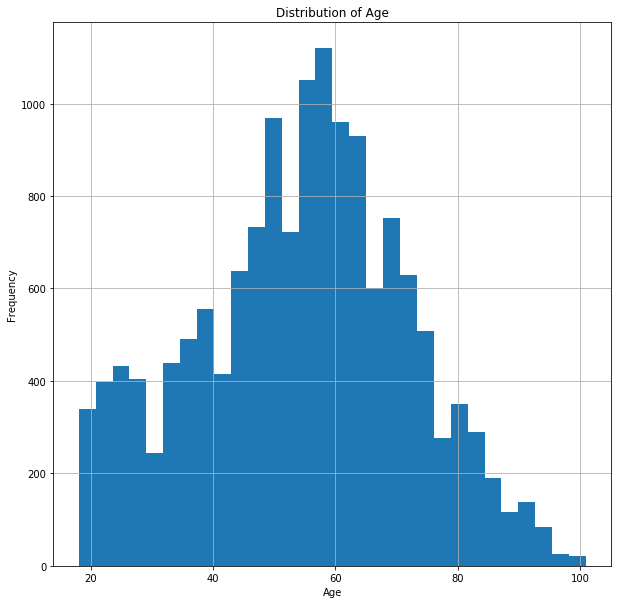

In [36]:
# Plot the histogram of the distribution of the age column
profile_clean.age.hist(bins= 30, figsize=(10, 10))
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');

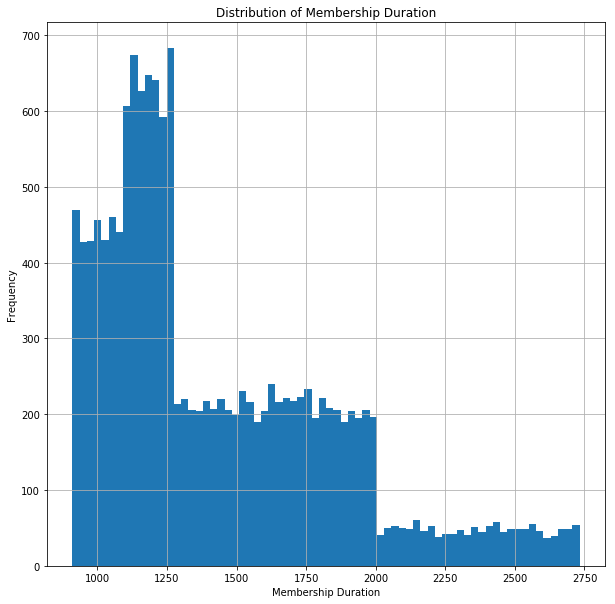

In [37]:
profile_clean.membership_days.hist(bins= 70, figsize=(10, 10))
plt.title('Distribution of Membership Duration')
plt.xlabel('Membership Duration')
plt.ylabel('Frequency');

## 3) Transcript Data Set

In [38]:
def clean_transcript(transcript):
    '''
    cleans the transcript dataframe, returns a new dataframe that will consist of offer events
    
    INPUT:
    transcript - dataframe to be cleaned
    
    OUTPUT:
    offers_df - the cleaned dataframe
    
    '''
    # Make a copy of the profile dataframe
    transcript_clean = transcript.copy()
    # extract rows that contains actions related to offers, such as, offer received, offer viewed, offer completed
    offers_df = transcript_clean[transcript_clean['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offers_df['offer_id'] = offers_df['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offers_df

In [39]:
offers_df = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
# Assess the shape of the offers dataframe
offers_df.shape

(167581, 5)

In [41]:
# Assess the first five rows of the offers_df
offers_df.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [42]:
# Asses the event column of the offers dataframe for the unique values in the column
offers_df.event.unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [43]:
# Explore the amount of offers sent out
offers_df[offers_df['event']=='offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [44]:
# Explore the offers sent to a particular customer
offers_df.query("person == '78afa995795e4d85b5d9ceeca43f5fef'")

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
163375,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
218394,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd
218395,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d


In [45]:
offers_df.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

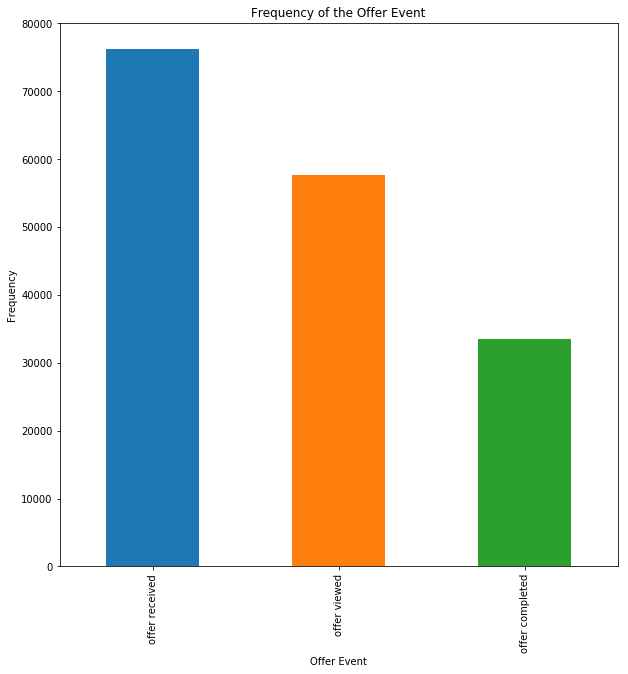

In [46]:
# Plot a bar chart to show the frequency of the various event types
offers_df.event.value_counts().plot(kind='bar', figsize=(10, 10))
plt.title('Frequency of the Offer Event')
plt.xlabel('Offer Event')
plt.ylabel('Frequency');

In [47]:
def create_user_item_matrix(offers_df, filename):
    '''
    Return the user item matrix that shows the number of completed offers by a certain customer 
    
    INPUT:
    offers_df - a cleaned dataframe generated from the transcript dataframe
    filename(string) - the file name used to save user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix that characterizes
        - each user in a row 
        - the offers in column
        - value represents the number of completed offer by the user (NaN represents non offers)

    
    '''
    # create an empty user item matrix
    user_item_matrix = offers_df.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offers_df[(offers_df['offer_id']==offer_id) & (offers_df['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    
                    # Check the order of transaction to confirm it is in offer received, offer viewed, and offer completed
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # save the martix into a file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [48]:
df = pickle.load(open("user_item_matrix.p","rb"))

In [49]:
df = create_user_item_matrix(offers_df, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [50]:
# View the first five rows of the dataframe
df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [51]:
# Split the dataframe into train and test data 
train, test = train_test_split(offers_df, test_size=0.3)

In [52]:
# Assign the train data into variable name train_size
train_size = train.shape[0]
train_size

117306

In [53]:
# Assign the test data into variable name test_size
test_size = test.shape[0]
test_size

50275

In [54]:
# View the size of the train and test data set
train_size, test_size

(117306, 50275)

In [55]:
offers_train = offers_df[:train_size]

In [56]:
offers_test = offers_df[train_size:]

In [57]:
df_train = create_user_item_matrix(offers_train, 'df_train.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [58]:
df_train.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [59]:
df_test = create_user_item_matrix(offers_test, 'df_test.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [60]:
df_test.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [61]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iterations=100):
    '''
    A function that implements matrix factorization by using a simple form of FunkSVD without regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix that contains the users in rows, offers in columns, and the offers completed as values
    latent_features - (int) the number of latent features 
    learning_rate - (float) the learning rate 
    iterations - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Create variables that will be used to be used for the function
    num_users = complete_mat.shape[0]
    num_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # Create the user and movie matrices with random values
    user_mat = np.random.rand(num_users, latent_features)
    offer_mat = np.random.rand(latent_features, num_offers)
    
    # Assign a value of 0 to the sse_accum variable for the first iteration
    sse_accum = 0
    
    # Print the values of the iteration and MSE
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    
    for iteration in range(iterations):

        # Update the sse_accum
        old_sse = sse_accum
        sse_accum = 0
        
        # Write a for loop that loops through each user-offer pair
        for i in range(num_users):
            for j in range(num_offers):
                
                # If the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # Subtract the dot product of the user and offer latent features from the actual to get the error
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Record sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # Update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # Print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [62]:
df = pd.read_pickle('user_item_matrix.p')

In [63]:
df_train = pd.read_pickle('df_train.p')

In [64]:
df_test = pd.read_pickle('df_test.p')

In [65]:
# Create user-by-item matrix
train_np = np.array(df_train)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_np, latent_features=15, learning_rate=0.005, iterations=250)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.316484
2 		 0.267098
3 		 0.266726
4 		 0.266344
5 		 0.265957
6 		 0.265564
7 		 0.265163
8 		 0.264755
9 		 0.264339
10 		 0.263915
11 		 0.263481
12 		 0.263037
13 		 0.262583
14 		 0.262117
15 		 0.261639
16 		 0.261147
17 		 0.260642
18 		 0.260121
19 		 0.259583
20 		 0.259028
21 		 0.258455
22 		 0.257861
23 		 0.257245
24 		 0.256607
25 		 0.255943
26 		 0.255254
27 		 0.254536
28 		 0.253788
29 		 0.253009
30 		 0.252195
31 		 0.251345
32 		 0.250458
33 		 0.249529
34 		 0.248558
35 		 0.247541
36 		 0.246477
37 		 0.245363
38 		 0.244195
39 		 0.242973
40 		 0.241693
41 		 0.240352
42 		 0.238948
43 		 0.237480
44 		 0.235943
45 		 0.234337
46 		 0.232660
47 		 0.230909
48 		 0.229083
49 		 0.227181
50 		 0.225202
51 		 0.223145
52 		 0.221009
53 		 0.218795
54 		 0.216503
55 		 0.214134
56 		 0.211689
57 		 0.209170
58 		 0.206578
59 		 0.203917
60 		 0.201190
61 		 0.198399
62 		 0.195548
63 		 0.192641
64 		 0

In [66]:
user_mat_10_features, offer_mat_10_features = FunkSVD(train_np, latent_features=10, learning_rate=0.005, iterations=250)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.296470
2 		 0.266946
3 		 0.266475
4 		 0.265995
5 		 0.265513
6 		 0.265027
7 		 0.264538
8 		 0.264045
9 		 0.263548
10 		 0.263047
11 		 0.262541
12 		 0.262030
13 		 0.261514
14 		 0.260993
15 		 0.260465
16 		 0.259931
17 		 0.259390
18 		 0.258841
19 		 0.258285
20 		 0.257720
21 		 0.257146
22 		 0.256562
23 		 0.255968
24 		 0.255363
25 		 0.254746
26 		 0.254116
27 		 0.253473
28 		 0.252815
29 		 0.252142
30 		 0.251453
31 		 0.250746
32 		 0.250021
33 		 0.249276
34 		 0.248510
35 		 0.247722
36 		 0.246911
37 		 0.246074
38 		 0.245211
39 		 0.244320
40 		 0.243400
41 		 0.242448
42 		 0.241464
43 		 0.240445
44 		 0.239389
45 		 0.238295
46 		 0.237161
47 		 0.235985
48 		 0.234766
49 		 0.233500
50 		 0.232187
51 		 0.230824
52 		 0.229409
53 		 0.227942
54 		 0.226419
55 		 0.224840
56 		 0.223202
57 		 0.221505
58 		 0.219747
59 		 0.217926
60 		 0.216043
61 		 0.214096
62 		 0.212085
63 		 0.210009
64 		 0

In [67]:
user_mat_5_features, offer_mat_5_features = FunkSVD(train_np, latent_features=5, learning_rate=0.005, iterations=250)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.281207
2 		 0.269129
3 		 0.268291
4 		 0.267450
5 		 0.266608
6 		 0.265765
7 		 0.264921
8 		 0.264076
9 		 0.263230
10 		 0.262383
11 		 0.261535
12 		 0.260685
13 		 0.259835
14 		 0.258983
15 		 0.258129
16 		 0.257274
17 		 0.256418
18 		 0.255559
19 		 0.254699
20 		 0.253837
21 		 0.252973
22 		 0.252106
23 		 0.251237
24 		 0.250365
25 		 0.249490
26 		 0.248613
27 		 0.247731
28 		 0.246847
29 		 0.245958
30 		 0.245065
31 		 0.244168
32 		 0.243267
33 		 0.242360
34 		 0.241447
35 		 0.240529
36 		 0.239605
37 		 0.238674
38 		 0.237737
39 		 0.236792
40 		 0.235839
41 		 0.234877
42 		 0.233907
43 		 0.232928
44 		 0.231938
45 		 0.230939
46 		 0.229928
47 		 0.228906
48 		 0.227871
49 		 0.226824
50 		 0.225764
51 		 0.224690
52 		 0.223601
53 		 0.222497
54 		 0.221377
55 		 0.220241
56 		 0.219087
57 		 0.217916
58 		 0.216726
59 		 0.215518
60 		 0.214290
61 		 0.213041
62 		 0.211772
63 		 0.210482
64 		 0

In [68]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    Write a function to predict consumers reactions to the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    prediction - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that match the ordering in training data
        user_ids_array = np.array(df_train.index)
        offer_ids_array = np.array(df_train.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_array == user_id)[0][0]
        offer_col = np.where(offer_ids_array == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        prediction = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return prediction
    
    except:
    
        return None

In [69]:
def validation(df_test, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(df_test))
    
    sse_accum = 0
    
    for user_id in df_test.index:
        for offer_id in df_test.columns:
            if ~np.isnan(df_test.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = df_test.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [70]:
# Evaluation for latent features of 15
validation(df_test, user_mat, offer_mat)

0.328115730152


In [71]:
validation(df_test, user_mat_10_features, offer_mat_10_features)

0.330957418958


In [72]:
validation(df_test, user_mat_5_features, offer_mat_5_features)

0.318728971945


In [78]:
def best_offer(user_item_matrix):
    """
    Write a function to figure out the offer with the most sales
    """
    offer_discount = []
    for offer_id in user_item_matrix.columns:
        offer_discount.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    top_value = pd.DataFrame(offer_discount, columns=['offer_id', 'gain'])
    top_value['gain'] = pd.to_numeric(top_value['gain'])
    top_value.sort_values(by='gain', ascending=False, inplace=True)
    print(top_value)
    
    major_sale = top_value.plot(kind='bar', title='Sale Amount of Different Offers')
    major_sale.set_xlabel('Offer number')
    major_sale.set_ylabel('Sale Amount')
    
    return top_value

In [81]:
def offer_recommendation(user_id, user_mat, offer_mat):
    recommendation = {}
    for offer_id in df_train.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommendation[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("This user id is not in our database, However, we are offering the best sale recommendations for all users.")
        best_sale = best_offer(df)
        for offer_id in best_sale['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("offer recommendation for user: ", user_id)
        for offer_id, pred_val in sorted(recommendation.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [82]:
# recommend offer for a particular user
offer_recommendation('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

offer recommendation for user:  0610b486422d4921ae7d2bf64640c50b
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.61
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.37
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.29
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.02
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  -0.03
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  -0.23
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.46
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.67


This user id is not in our database, However, we are offering the best sale recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


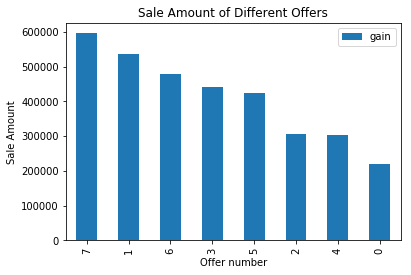

In [83]:
offer_recommendation('new_user', user_mat, offer_mat)

In [84]:
def gender_offer_distribution(df):
    '''
    Write a function to figure out the offer type that attracts the various genders
    Return with a plotted bar chart
    '''
    
    # Set up the gender replies and the offer sent grouped by gender dataframe
    replies_by_gender = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    offers_by_gender = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # Count the number of offer completed based on the gender of the customer
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers that replied to the offers
            replies_by_gender[offer_type] = replies_by_gender[offer_type].add(profile[profile['id'].isin(df[df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offers sent to the varying gender
            offers_by_gender[offer_type] = offers_by_gender[offer_type].add(profile[profile['id'].isin(df[df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer_distribution = (replies_by_gender / offers_by_gender * 100).plot(kind='bar', title='Percentage of customer response', figsize=(10, 10))
    gender_offer_distribution.set_xlabel("Gender")
    gender_offer_distribution.set_ylabel("Percentage")

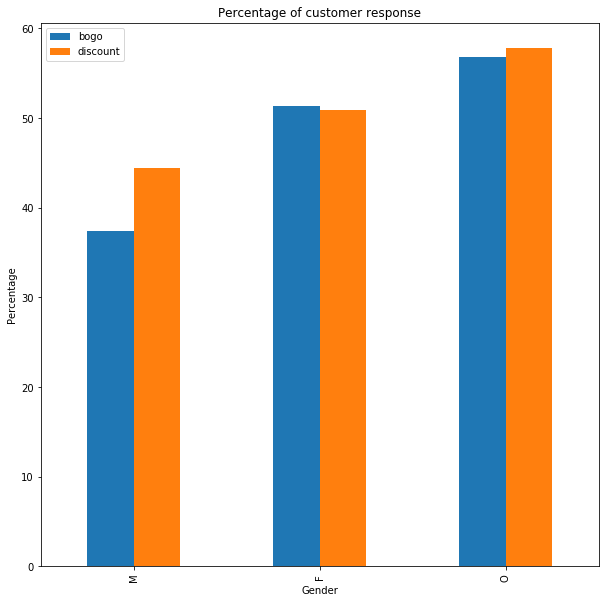

In [85]:
gender_offer_distribution(df)

In [86]:
portfolio_clean

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


In [87]:
def offer_channel_by_gender(df):
    '''
    Write a functions that figures out the type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    replies_by_gender = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    offers_by_gender = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # Count the number of offer completed based on the gender of the customers
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in portfolio_clean[(portfolio_clean[channel_type]==1)&(portfolio_clean['informational']!=1)]['id']:
            # count the total number of customers that replied to the offers.
            replies_by_gender[channel_type] = replies_by_gender[channel_type].add(profile[profile['id'].isin(df[df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offers sent
            offers_by_gender[channel_type] = offers_by_gender[channel_type].add(profile[profile['id'].isin(df[df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (replies_by_gender / offers_by_gender * 100).plot(kind='bar', title='Percentage of customer response to the Medium of offer sent',figsize=(10,10))
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

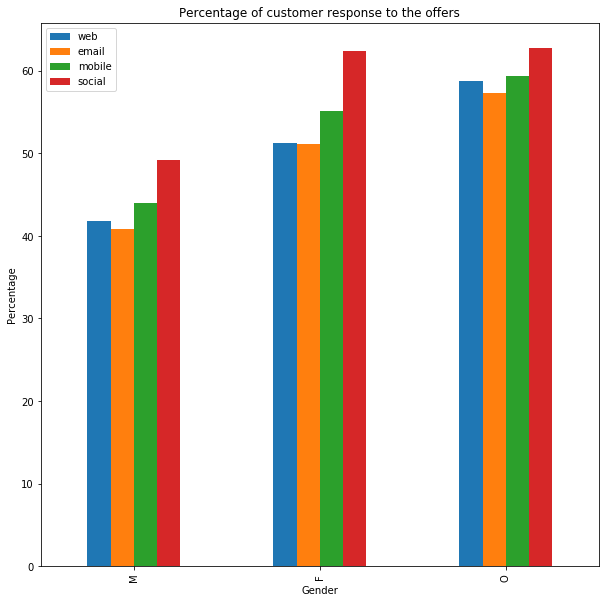

In [88]:
offer_channel_by_gender(df)

## Improvement

Due to the number of missing values in the data set. The best course of action was to implement FUNKSVD. However, the downside to this was the inability to make recommendations for new users. This caused me to introduce ranked based recommendation systems that would return the best promotional offers for new users. 

Another way this could have been improved will be to split the data into a more precise training and testing data. This can help keep better records of the promotional offers sent to the customer and track if it was completed by the customers. It will provide accuracy to the user-offer pair matrix and the trained model.